In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import time
import shutil
import pathlib
import itertools
import tensorflow as tf

from PIL import Image
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,
                                     GaussianNoise, Input, Reshape)

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNet

In [2]:
import os
for dirname, _, filenames in os.walk('ovarian-cancer-classification-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ovarian-cancer-classification-dataset\mobilenet_model_224x224_30_10.h5
ovarian-cancer-classification-dataset\Test_Images\CC\10360.png
ovarian-cancer-classification-dataset\Test_Images\CC\10361.png
ovarian-cancer-classification-dataset\Test_Images\CC\10377.png
ovarian-cancer-classification-dataset\Test_Images\CC\10383.png
ovarian-cancer-classification-dataset\Test_Images\CC\10384.png
ovarian-cancer-classification-dataset\Test_Images\CC\10390.png
ovarian-cancer-classification-dataset\Test_Images\CC\10392.png
ovarian-cancer-classification-dataset\Test_Images\CC\1093.png
ovarian-cancer-classification-dataset\Test_Images\CC\1094.png
ovarian-cancer-classification-dataset\Test_Images\CC\1114.png
ovarian-cancer-classification-dataset\Test_Images\CC\1120.png
ovarian-cancer-classification-dataset\Test_Images\CC\1131.png
ovarian-cancer-classification-dataset\Test_Images\CC\11375.png
ovarian-cancer-classification-dataset\Test_Images\CC\11379.png
ovarian-cancer-classification-dataset\Test_Images\CC

In [3]:
dataset_path = "ovarian-cancer-classification-dataset/Test_Images"

In [4]:
data = []

for label in os.listdir(dataset_path):
    
    sub_dir = os.path.join(dataset_path, label)
    
    if os.path.isdir(sub_dir):
    
        for file_name in os.listdir(sub_dir):
            
            file_path = os.path.join(sub_dir, file_name)
            
            data.append([file_path, label])

df = pd.DataFrame(data, columns=['file_path', 'label'])

In [5]:
df.head()

file_path label
0  ovarian-cancer-classification-dataset/Test_Ima...    CC
1  ovarian-cancer-classification-dataset/Test_Ima...    CC
2  ovarian-cancer-classification-dataset/Test_Ima...    CC
3  ovarian-cancer-classification-dataset/Test_Ima...    CC
4  ovarian-cancer-classification-dataset/Test_Ima...    CC

In [6]:
df.tail()

file_path label
3077  ovarian-cancer-classification-dataset/Test_Ima...    MC
3078  ovarian-cancer-classification-dataset/Test_Ima...    MC
3079  ovarian-cancer-classification-dataset/Test_Ima...    MC
3080  ovarian-cancer-classification-dataset/Test_Ima...    MC
3081  ovarian-cancer-classification-dataset/Test_Ima...    MC

In [7]:
df.shape

(3082, 2)

In [8]:
df.columns

Index(['file_path', 'label'], dtype='object')

In [9]:
df.duplicated().sum()

0

In [10]:
df.isnull().sum()

file_path    0
label        0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3082 entries, 0 to 3081
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  3082 non-null   object
 1   label      3082 non-null   object
dtypes: object(2)
memory usage: 48.3+ KB


In [12]:
df['label'].unique()

array(['CC', 'EC', 'HGSC', 'LGSC', 'MC'], dtype=object)

In [13]:
df['label'].value_counts()

label
HGSC    1188
EC       733
CC       551
MC       323
LGSC     287
Name: count, dtype: int64

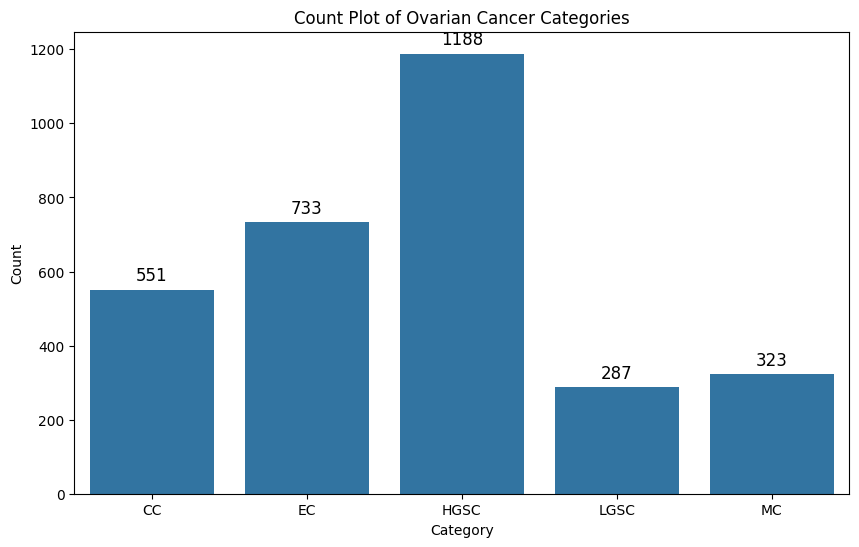

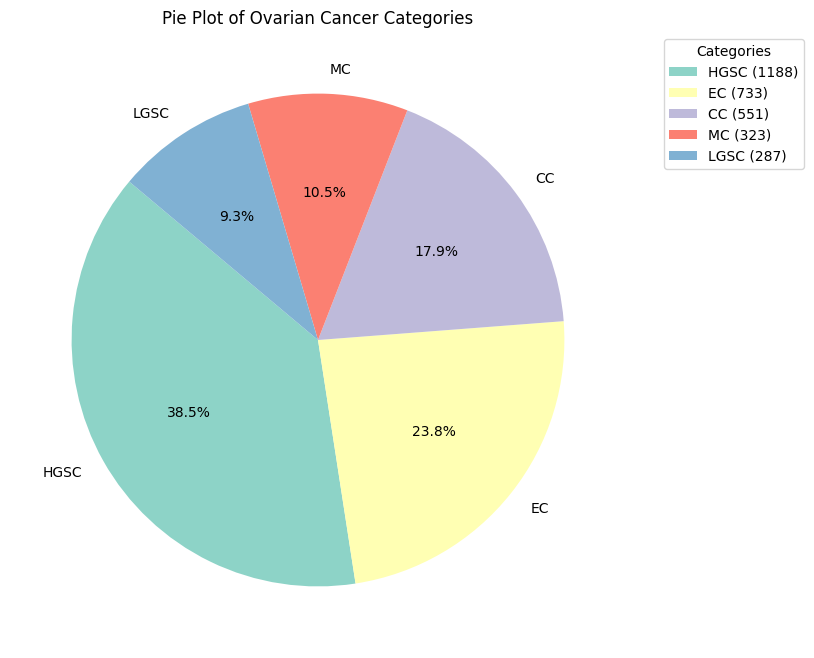

In [14]:
plt.figure(figsize=(10, 6))
count_plot = sns.countplot(x='label', data=df)
plt.title("Count Plot of Ovarian Cancer Categories")
plt.xlabel("Category")
plt.ylabel("Count")

for p in count_plot.patches:
    count_plot.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 10), textcoords='offset points', fontsize=12)

plt.show()

plt.figure(figsize=(8, 8))
category_counts = df['label'].value_counts()
pie_plot = category_counts.plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title("Pie Plot of Ovarian Cancer Categories")
plt.ylabel("")  

labels_with_counts = [f'{label} ({count})' for label, count in zip(category_counts.index, category_counts.values)]
plt.legend(labels_with_counts, title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

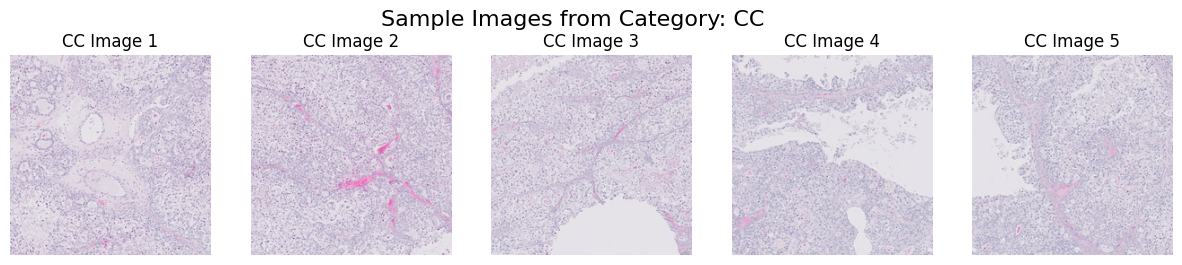

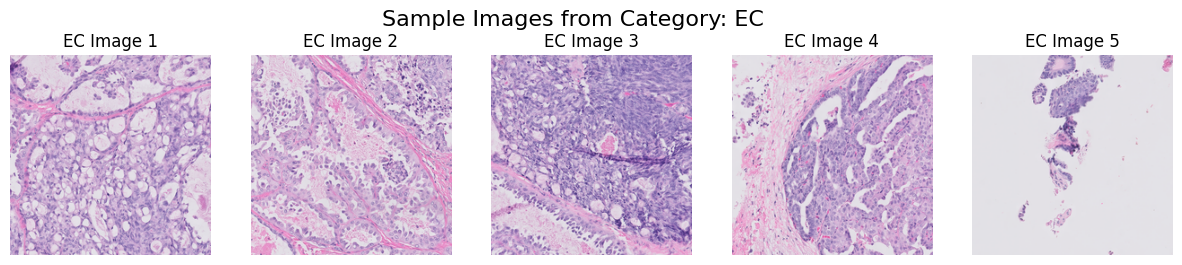

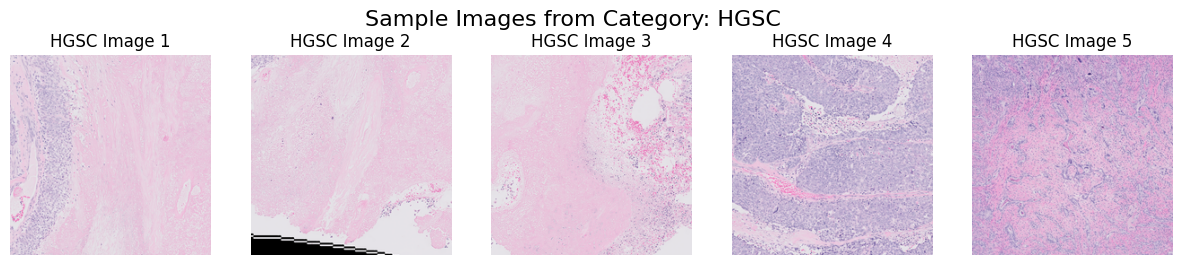

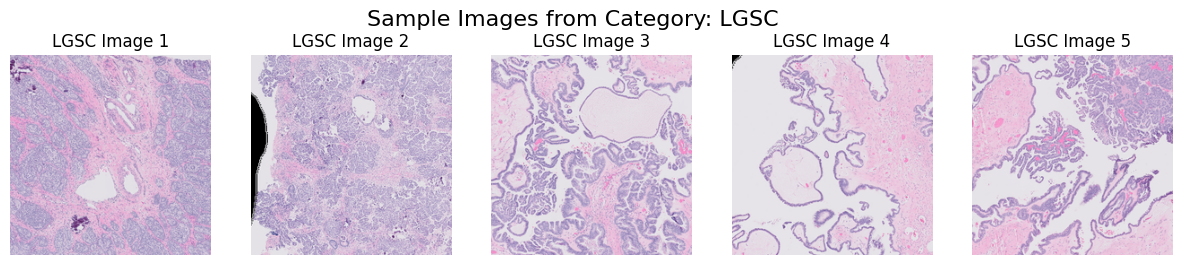

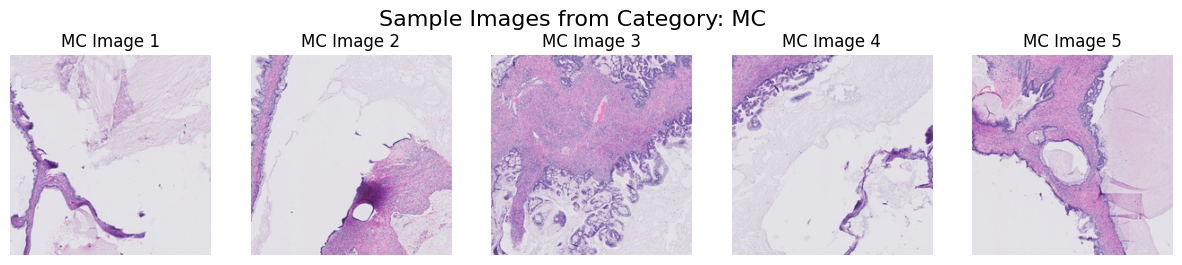

In [15]:
categories = os.listdir(dataset_path)

num_images = 5

for category in categories:
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)[:num_images]  

    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Sample Images from Category: {category}', fontsize=16)

    for i, image_name in enumerate(images):

        image_path = os.path.join(category_path, image_name)
        img = Image.open(image_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{category} Image {i+1}')

    plt.show()

In [16]:
label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [17]:
df = df[['file_path', 'category_encoded']]

In [18]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['file_path']], df['category_encoded'])

In [19]:
df_resampled = pd.DataFrame(X_resampled, columns=['file_path'])
df_resampled['category_encoded'] = y_resampled

In [20]:
print("\nClass distribution after oversampling => ")
print(df_resampled['category_encoded'].value_counts())


Class distribution after oversampling => 
category_encoded
0    1188
1    1188
2    1188
3    1188
4    1188
Name: count, dtype: int64


In [21]:
df_resampled

file_path  category_encoded
0     ovarian-cancer-classification-dataset/Test_Ima...                 0
1     ovarian-cancer-classification-dataset/Test_Ima...                 0
2     ovarian-cancer-classification-dataset/Test_Ima...                 0
3     ovarian-cancer-classification-dataset/Test_Ima...                 0
4     ovarian-cancer-classification-dataset/Test_Ima...                 0
...                                                 ...               ...
5935  ovarian-cancer-classification-dataset/Test_Ima...                 4
5936  ovarian-cancer-classification-dataset/Test_Ima...                 4
5937  ovarian-cancer-classification-dataset/Test_Ima...                 4
5938  ovarian-cancer-classification-dataset/Test_Ima...                 4
5939  ovarian-cancer-classification-dataset/Test_Ima...                 4

[5940 rows x 2 columns]

In [22]:
sns.set_style('darkgrid')

In [23]:
import warnings
warnings.filterwarnings("ignore")

print ('Check.....')

Check.....


In [24]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [25]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,  
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']  
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded'] 
)

In [26]:
batch_size = 16
img_size = (224, 224)
channels = 3  
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)  
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='file_path',  
    y_col='category_encoded',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='file_path',  
    y_col='category_encoded',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='file_path', 
    y_col='category_encoded',    
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=False,  
    batch_size=batch_size
)

Found 4752 validated image filenames belonging to 5 classes.
Found 594 validated image filenames belonging to 5 classes.
Found 594 validated image filenames belonging to 5 classes.


In [27]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [29]:
class DifferentialAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(DifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        
    def build(self, input_shape):
        self.query_dense = tf.keras.layers.Dense(self.key_dim)
        self.key_dense = tf.keras.layers.Dense(self.key_dim)
        self.value_dense = tf.keras.layers.Dense(self.key_dim)

    def call(self, x):
      
        Q = self.query_dense(x)
        K = self.key_dense(x)
        V = self.value_dense(x)
        
        
        attention_scores = tf.einsum('...ij,...kj->...ik', Q, K)  
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)  
        
        sparse_attention = attention_scores * tf.cast((attention_scores > tf.reduce_mean(attention_scores)), tf.float32)
        
        output = tf.einsum('...ij,...jk->...ik', sparse_attention, V)
        
        return output

def create_inception_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = InceptionV3(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    height, width, channels = 5, 5, 2048  
    x = Reshape((height * width, channels))(x)

    attention_output = DifferentialAttention(num_heads=8, key_dim=channels)(x)
    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(5, activation='softmax')(x)  

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (224, 224, 3)
cnn_model = create_inception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [30]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 164s 518ms/step - accuracy: 0.3544 - loss: 1.8562 - val_accuracy: 0.5017 - val_loss: 1.3707
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 152s 513ms/step - accuracy: 0.5717 - loss: 1.1429 - val_accuracy: 0.5455 - val_loss: 1.2762
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 153s 515ms/step - accuracy: 0.6755 - loss: 0.8873 - val_accuracy: 0.6246 - val_loss: 1.0113
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 155s 522ms/step - accuracy: 0.7131 - loss: 0.7627 - val_accuracy: 0.6633 - val_loss: 0.9397
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 159s 535ms/step - accuracy: 0.7409 - loss: 0.6824 - val_accuracy: 0.6094 - val_loss: 1.1664


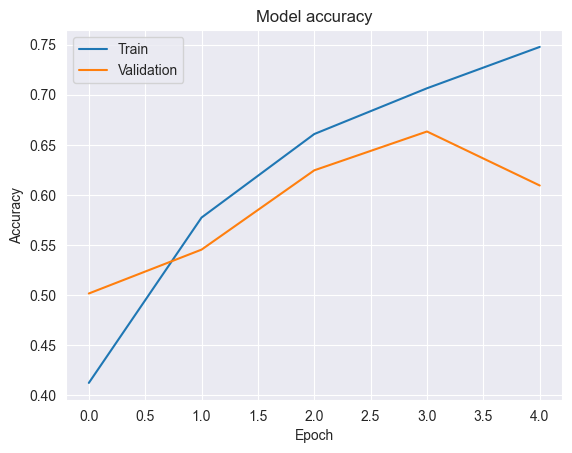

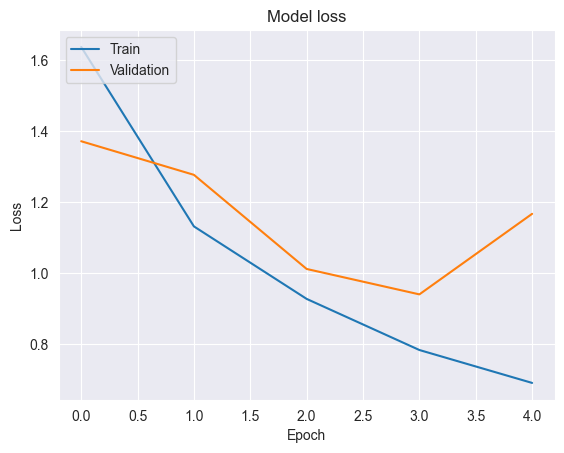

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 417ms/step


In [33]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       119
           1       0.54      0.50      0.52       119
           2       0.52      0.57      0.54       119
           3       0.86      0.71      0.77       119
           4       0.78      0.88      0.83       118

    accuracy                           0.69       594
   macro avg       0.69      0.69      0.69       594
weighted avg       0.69      0.69      0.69       594



In [34]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

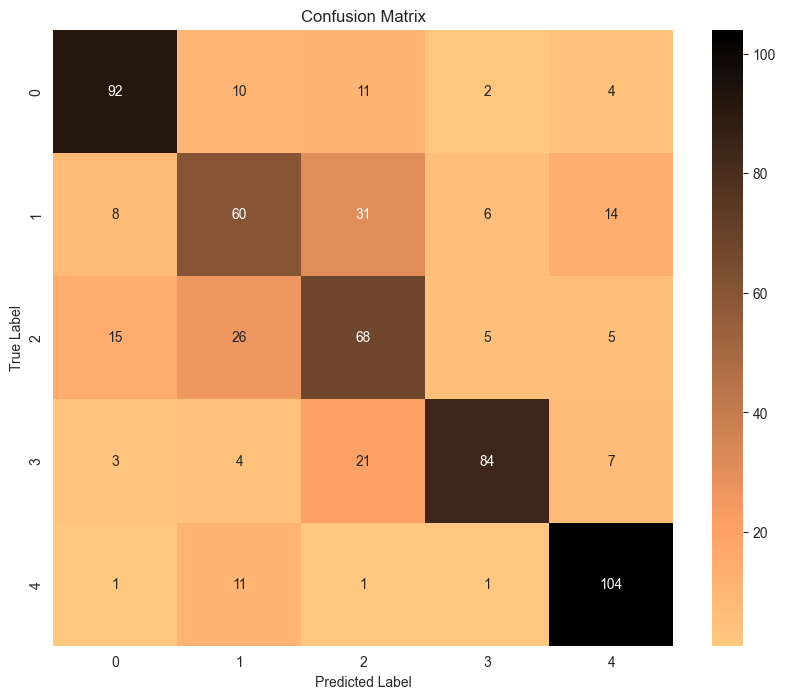

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='copper_r', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [36]:
class DifferentialAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(DifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        
    def build(self, input_shape):
        self.query_dense = tf.keras.layers.Dense(self.key_dim)
        self.key_dense = tf.keras.layers.Dense(self.key_dim)
        self.value_dense = tf.keras.layers.Dense(self.key_dim)

    def call(self, x):
        Q = self.query_dense(x)
        K = self.key_dense(x)
        V = self.value_dense(x)
        
        attention_scores = tf.einsum('...ij,...kj->...ik', Q, K)  
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)  
        
        sparse_attention = attention_scores * tf.cast((attention_scores > tf.reduce_mean(attention_scores)), tf.float32)
        
        output = tf.einsum('...ij,...jk->...ik', sparse_attention, V)
        
        return output

def create_xception_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = Xception(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    height, width, channels = 7, 7, 2048  
    x = Reshape((height * width, channels))(x)

    attention_output = DifferentialAttention(num_heads=8, key_dim=channels)(x)
    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(5, activation='softmax')(x)  

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (224, 224, 3)
cnn_model = create_xception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [37]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 273s 900ms/step - accuracy: 0.2902 - loss: 1.8432 - val_accuracy: 0.4562 - val_loss: 1.3852
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 260s 875ms/step - accuracy: 0.4840 - loss: 1.2997 - val_accuracy: 0.5909 - val_loss: 1.1561
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 262s 882ms/step - accuracy: 0.6239 - loss: 0.9842 - val_accuracy: 0.6566 - val_loss: 0.9465
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 262s 882ms/step - accuracy: 0.6961 - loss: 0.7733 - val_accuracy: 0.6919 - val_loss: 0.8966
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 259s 871ms/step - accuracy: 0.7790 - loss: 0.6076 - val_accuracy: 0.7441 - val_loss: 0.8471


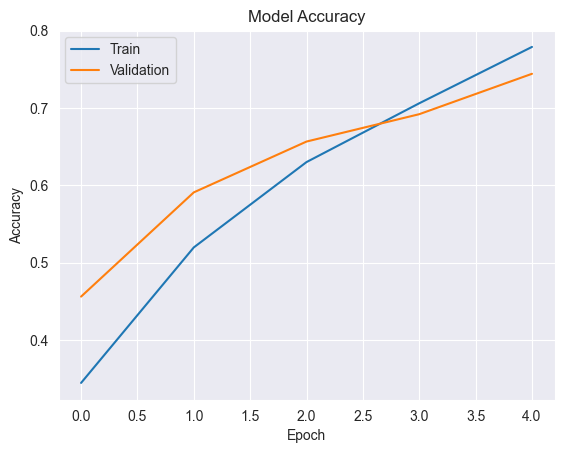

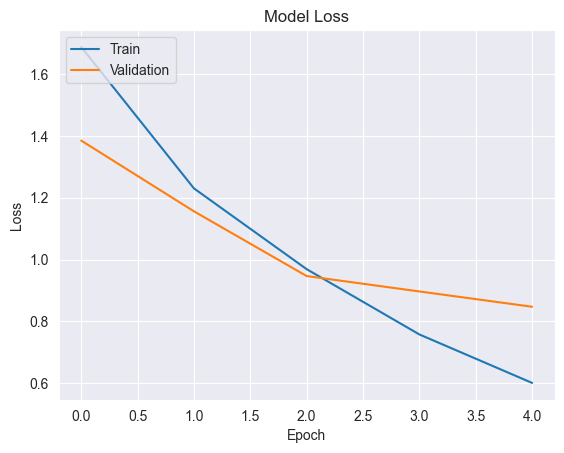

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [39]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 660ms/step


In [40]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       119
           1       0.76      0.61      0.67       119
           2       0.67      0.62      0.64       119
           3       0.84      0.85      0.85       119
           4       0.78      0.94      0.85       118

    accuracy                           0.78       594
   macro avg       0.77      0.78      0.77       594
weighted avg       0.77      0.78      0.77       594



In [41]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

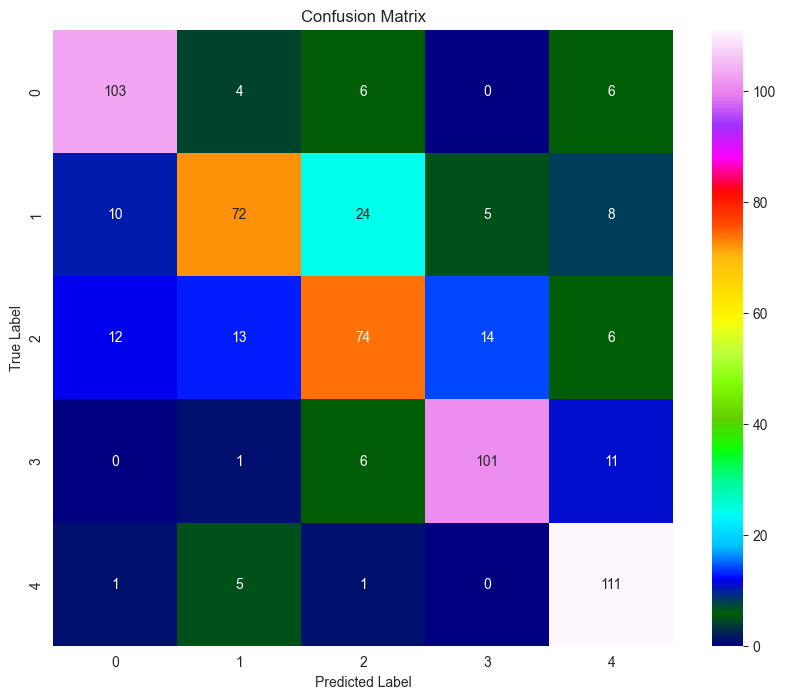

In [42]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='gist_ncar', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [43]:
class DifferentialAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(DifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        
    def build(self, input_shape):
        self.query_dense = tf.keras.layers.Dense(self.key_dim)
        self.key_dense = tf.keras.layers.Dense(self.key_dim)
        self.value_dense = tf.keras.layers.Dense(self.key_dim)

    def call(self, x):
        Q = self.query_dense(x)
        K = self.key_dense(x)
        V = self.value_dense(x)
        
        attention_scores = tf.einsum('...ij,...kj->...ik', Q, K)  
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)  
        
        sparse_attention = attention_scores * tf.cast((attention_scores > tf.reduce_mean(attention_scores)), tf.float32)
        
        output = tf.einsum('...ij,...jk->...ik', sparse_attention, V)
        
        return output

def create_mobilenet_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = MobileNet(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    height, width, channels = 7, 7, 1024  
    x = Reshape((height * width, channels))(x)

    attention_output = DifferentialAttention(num_heads=8, key_dim=channels)(x)
    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(5, activation='softmax')(x)  

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [44]:
input_shape = (224, 224, 3)
cnn_model = create_mobilenet_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [45]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 200ms/step - accuracy: 0.3762 - loss: 1.7879 - val_accuracy: 0.6296 - val_loss: 1.0526
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 59s 198ms/step - accuracy: 0.6366 - loss: 0.9649 - val_accuracy: 0.6953 - val_loss: 0.8654
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 86s 289ms/step - accuracy: 0.7408 - loss: 0.7179 - val_accuracy: 0.7441 - val_loss: 0.7957
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 204ms/step - accuracy: 0.8087 - loss: 0.5371 - val_accuracy: 0.7677 - val_loss: 0.7540
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 60s 201ms/step - accuracy: 0.8367 - loss: 0.4591 - val_accuracy: 0.7795 - val_loss: 0.7119


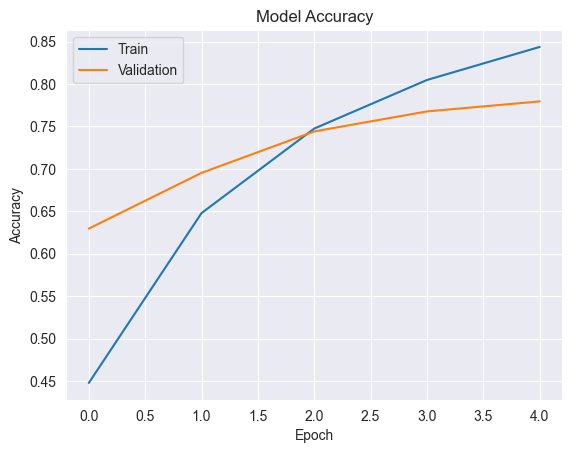

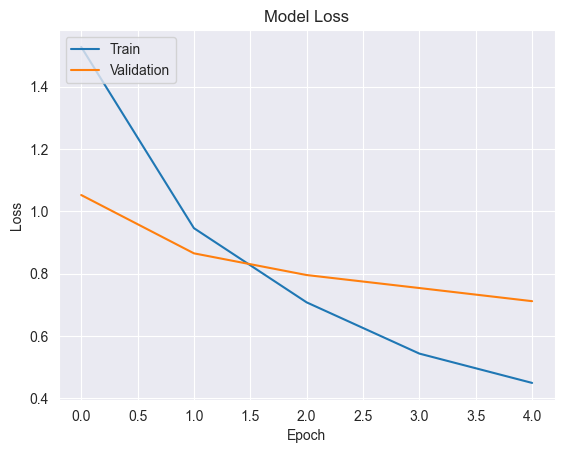

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [47]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step


In [48]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       119
           1       0.77      0.60      0.67       119
           2       0.63      0.60      0.61       119
           3       0.88      0.91      0.89       119
           4       0.82      0.97      0.89       118

    accuracy                           0.79       594
   macro avg       0.79      0.79      0.78       594
weighted avg       0.78      0.79      0.78       594



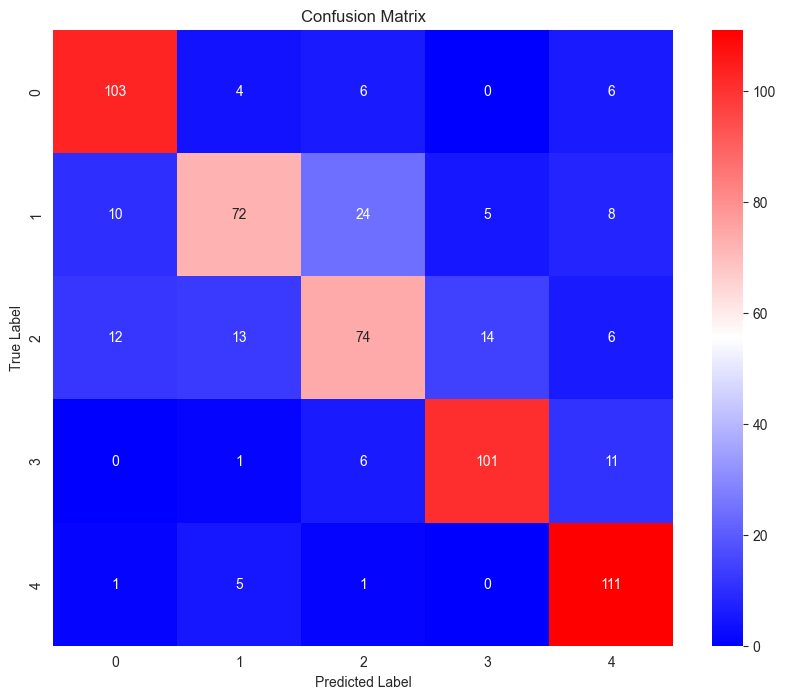

In [49]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='bwr', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

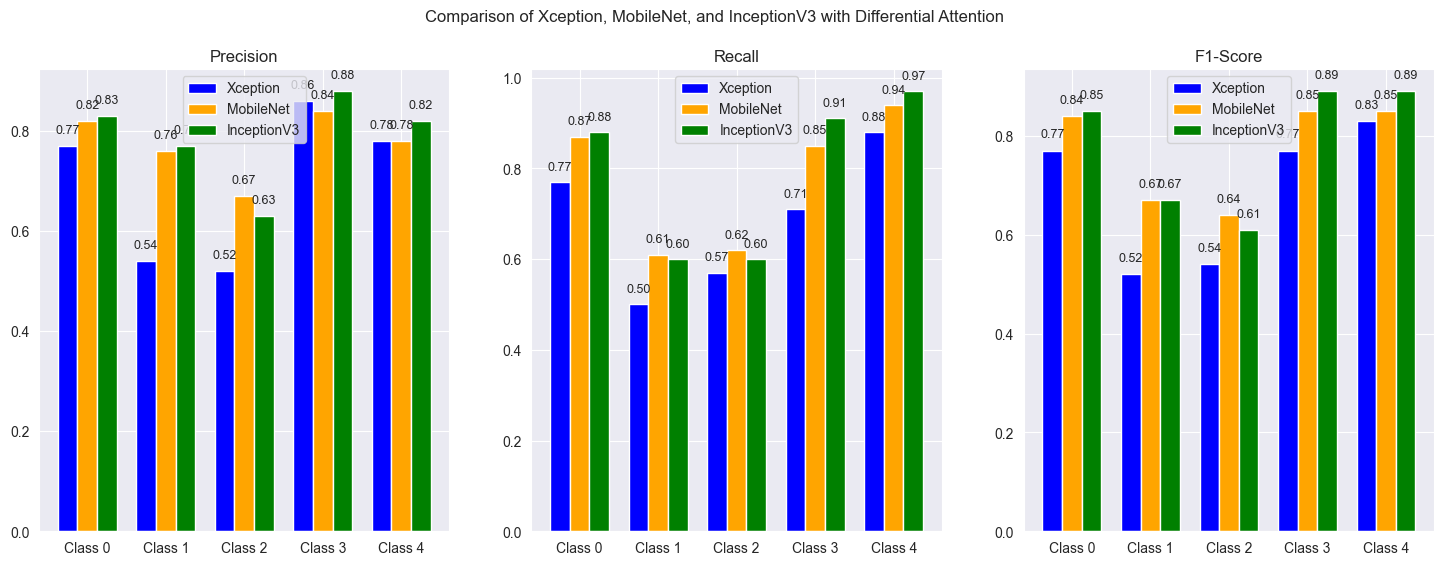

In [51]:
xception_metrics = {
    "precision": [0.77, 0.54, 0.52, 0.86, 0.78],
    "recall": [0.77, 0.50, 0.57, 0.71, 0.88],
    "f1-score": [0.77, 0.52, 0.54, 0.77, 0.83]
}

mobilenet_metrics = {
    "precision": [0.82, 0.76, 0.67, 0.84, 0.78],
    "recall": [0.87, 0.61, 0.62, 0.85, 0.94],
    "f1-score": [0.84, 0.67, 0.64, 0.85, 0.85]
}

inceptionv3_metrics = {
    "precision": [0.83, 0.77, 0.63, 0.88, 0.82],
    "recall": [0.88, 0.60, 0.60, 0.91, 0.97],
    "f1-score": [0.85, 0.67, 0.61, 0.89, 0.89]
}

classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

bar_width = 0.25
x = np.arange(len(classes))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Comparison of Xception, MobileNet, and InceptionV3 with Differential Attention")

def add_annotations(ax, data, x_positions):
    for i, v in enumerate(data):
        ax.text(x_positions[i], v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

axs[0].bar(x - bar_width, xception_metrics["precision"], width=bar_width, label="Xception", color='blue')
axs[0].bar(x, mobilenet_metrics["precision"], width=bar_width, label="MobileNet", color='orange')
axs[0].bar(x + bar_width, inceptionv3_metrics["precision"], width=bar_width, label="InceptionV3", color='green')
axs[0].set_title("Precision")
axs[0].set_xticks(x)
axs[0].set_xticklabels(classes)
add_annotations(axs[0], xception_metrics["precision"], x - bar_width)
add_annotations(axs[0], mobilenet_metrics["precision"], x)
add_annotations(axs[0], inceptionv3_metrics["precision"], x + bar_width)
axs[0].legend()

axs[1].bar(x - bar_width, xception_metrics["recall"], width=bar_width, label="Xception", color='blue')
axs[1].bar(x, mobilenet_metrics["recall"], width=bar_width, label="MobileNet", color='orange')
axs[1].bar(x + bar_width, inceptionv3_metrics["recall"], width=bar_width, label="InceptionV3", color='green')
axs[1].set_title("Recall")
axs[1].set_xticks(x)
axs[1].set_xticklabels(classes)
add_annotations(axs[1], xception_metrics["recall"], x - bar_width)
add_annotations(axs[1], mobilenet_metrics["recall"], x)
add_annotations(axs[1], inceptionv3_metrics["recall"], x + bar_width)
axs[1].legend()

axs[2].bar(x - bar_width, xception_metrics["f1-score"], width=bar_width, label="Xception", color='blue')
axs[2].bar(x, mobilenet_metrics["f1-score"], width=bar_width, label="MobileNet", color='orange')
axs[2].bar(x + bar_width, inceptionv3_metrics["f1-score"], width=bar_width, label="InceptionV3", color='green')
axs[2].set_title("F1-Score")
axs[2].set_xticks(x)
axs[2].set_xticklabels(classes)
add_annotations(axs[2], xception_metrics["f1-score"], x - bar_width)
add_annotations(axs[2], mobilenet_metrics["f1-score"], x)
add_annotations(axs[2], inceptionv3_metrics["f1-score"], x + bar_width)
axs[2].legend()

plt.show()